In [1]:
import sys
sys.path.append('../../')

import torch as tc
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

from rcgp.rcgp import SpatioTemporalRCGP
from matplotlib.colors import LinearSegmentedColormap

from tqdm import tqdm

from data.simulations import spatio_temporal_half_contaminated

plt.rc('font', family='serif', size=12)

In [2]:
def compute_nlpd(y_true, mu_pred, sigma_pred):

    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    mu_pred = np.array(mu_pred)
    sigma_pred = np.array(sigma_pred)
    
    # Avoid division by zero or invalid log by adding a small epsilon to sigma
    epsilon = 1e-8
    sigma_pred = np.maximum(sigma_pred, epsilon)
    
    # Compute log predictive density for Gaussian
    log_pdf = -0.5 * np.log(2 * np.pi * sigma_pred**2) - ((y_true - mu_pred)**2 / (2 * sigma_pred**2))
    
    # Compute and return the NLPD
    nlpd = -np.mean(log_pdf)
    return nlpd

def compute_rmse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    if len(y_true) != len(y_pred):
        raise ValueError("The lengths of y_true and y_pred must be the same.")
    
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse

In [3]:
ts, grids, Ys, true_Ys, Ys_no_outliers, outliers_loc, n_lon, n_lat, lon_norm, lat_norm = spatio_temporal_half_contaminated()

In [4]:
def scoring_rule(Ys : tc.Tensor, preds : tc.Tensor, covs : tc.Tensor, R : tc.Tensor, Ws: tc.Tensor):

    S = covs + R
    eps = Ys - preds

    mahalanobis_dist = (eps.mT @ tc.linalg.inv(S) @ eps).squeeze()
    norm_const = tc.logdet(2 * tc.pi * S)

    energies = 0.5 * (norm_const + mahalanobis_dist)
    
    return energies.sum()

# Training model on no outliers

100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


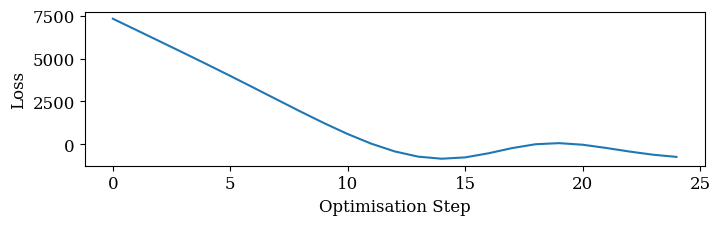

In [55]:
gp_std = SpatioTemporalRCGP(ts=ts, grid=grids[0], Ys=Ys_no_outliers, p=1)
gp_std.deactivate_robustness()

losses = []
n_steps = 25
lr = 0.3

optimizer = tc.optim.Adam(gp_std.parameters(), lr=lr)


for step in tqdm(range(n_steps)):
    _,(preds, covs, R, Ws), _ = gp_std.forward(smoothing=False)

    loss = scoring_rule(Ys=Ys_no_outliers, preds=preds, covs=covs, R=R, Ws=Ws)
    loss.backward()
    losses.append(loss.clone().detach())
    
    optimizer.step()  # Update parameters
    optimizer.zero_grad()  # Reset gradients

plt.figure(figsize=(8,2))
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Optimisation Step");

In [56]:
var_y = gp_std.var_y.clone().detach().item()
temporal_lengthscale = gp_std.temporal_lengthscale.clone().detach().item()
spatial_lengthscale = gp_std.spatial_lengthscale.clone().detach().item()
temporal_magnitude = gp_std.temporal_magnitude.clone().detach().item()
spatial_magnitude = gp_std.spatial_magnitude.clone().detach().item()

print(var_y)
print(temporal_lengthscale, spatial_lengthscale)
print(temporal_magnitude, spatial_magnitude)

0.03425326570868492
0.15441787242889404 6.181653022766113
3.440368890762329 3.4392268657684326


# Comparing prior means

In [57]:
def get_pred_prior_mean(prior_mean, data):

    model = SpatioTemporalRCGP(ts=ts, grid=grids[0], Ys=data, p=1)

    model.var_y = var_y
    model.temporal_lengthscale = temporal_lengthscale
    model.spatial_lengthscale = spatial_lengthscale
    model.temporal_magnitude = temporal_magnitude
    model.spatial_magnitude = spatial_magnitude

    if prior_mean==1:
        model.activate_robustness(func='constant')

    elif prior_mean==2:
        model.activate_robustness(func="local_constant")

    elif prior_mean==3:
        model.activate_robustness(func='m_pred')

    else:
        model.deactivate_robustness()

    with tc.no_grad():
        (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps) = model.forward(smoothing=True)

    return preds_smooth, stds_smooth, eff, model.var_y.clone().detach()


In [58]:
def plot_one_map(idx, grid, preds_smooth, eff, data, vmin, vmax, cmap='plasma'):

    fig, axs = plt.subplots(1,3,figsize=(14,4), sharey=True)

    x,y = grid[:,0].reshape(25,25), grid[:,1].reshape(25,25)
    z0, z1 = preds_smooth[idx, :].reshape(25,25), eff[idx, :].reshape(25,25)
    z2 = data[idx, :].reshape(25,25)


    c1 = axs[0].contourf(x, y, z0, cmap=cmap, vmin=vmin, vmax=vmax, extend='max')
    c2 = axs[1].contourf(x, y, z2, cmap=cmap, vmin=vmin, vmax=vmax, extend='max')
    c3 = axs[2].contourf(x, y, z1, cmap='Grays')

    print("Efficiency : ", eff[idx].mean())

    fig.colorbar(c2)
    fig.colorbar(c3)


Efficiency :  tensor(0.6333)


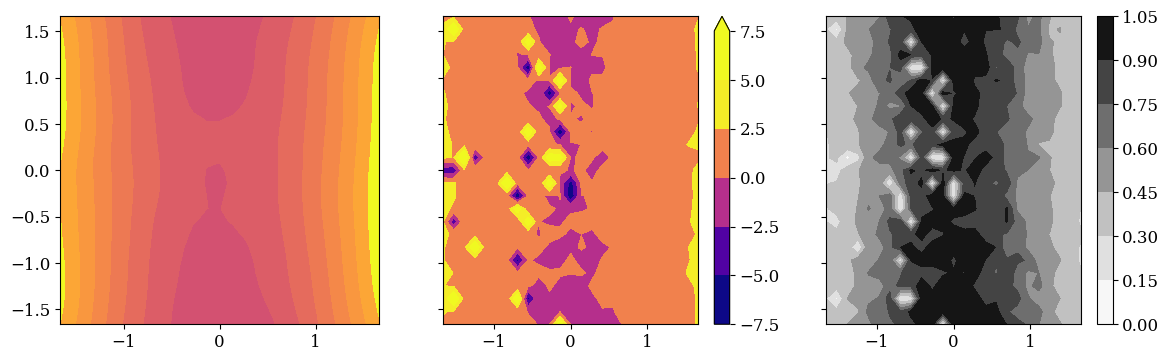

In [59]:
preds_smooth, stds_smooth, eff, var_y_test = get_pred_prior_mean(prior_mean=1, data=Ys)
plot_one_map(idx=1, grid=grids[0], preds_smooth=preds_smooth, data=Ys, eff=eff, vmin=-5, vmax=4)

Efficiency :  tensor(0.9286)


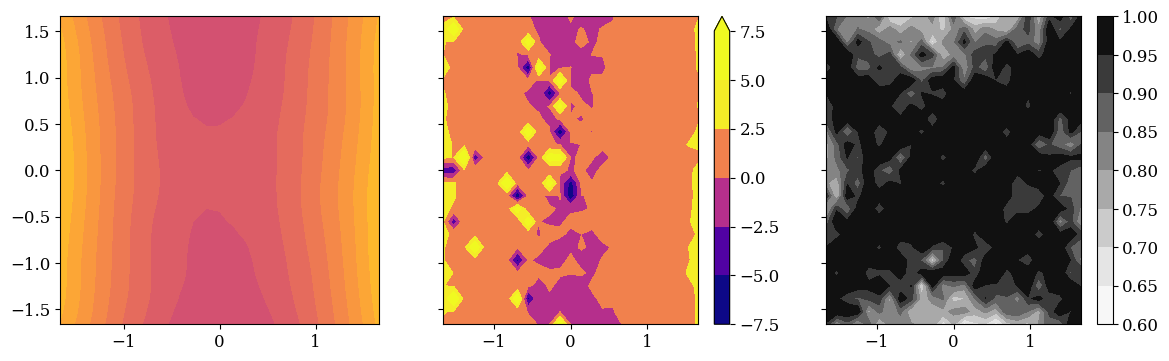

In [60]:
preds_smooth, stds_smooth, eff, var_y_test = get_pred_prior_mean(prior_mean=3, data=Ys_no_outliers)
plot_one_map(idx=1, grid=grids[0], preds_smooth=preds_smooth, data=Ys, eff=eff, vmin=-5, vmax=4)

In [62]:
def plot_multiple_prior_means(idx, grid, data, data_fit, vmin, vmax, cmap='plasma'):
    
    fig, axs = plt.subplots(2,4,figsize=(10,4), sharey=True, sharex=True)

    x,y = grid[:,0].reshape(25,25), grid[:,1].reshape(25,25)

    y_true = data[idx].reshape(25,25)


    for i, name in enumerate(["Data (STGP)", "Constant Mean (RCGP)", "Local Smoothing", "Filtering Predictive"]):
        preds_smooth, stds_smooth, eff, var_y = get_pred_prior_mean(prior_mean=i, data=data_fit)

        z0, z1, sigma_pred = preds_smooth[idx, :].reshape(25,25), eff[idx, :].reshape(25,25), stds_smooth[idx, :].reshape(25,25)

        sigma_pred += tc.sqrt(var_y)
        
        c0=axs[0, i].contourf(x, y, z0, cmap=cmap, vmin=vmin, vmax=vmax)
        c1=axs[1, i].contourf(x, y, z1, cmap='Grays', vmin=0, vmax=0.99)

        axs[0,i].set_title(name, fontsize=8)
        
        print(f"{name} : ")
        print("Efficiency :".format(name), z1.mean())
        print("NLPD : ", compute_nlpd(y_true=y_true, mu_pred=z0, sigma_pred=sigma_pred))
        print("RMSE : ", compute_rmse(y_true=y_true, y_pred=z0))
    
    fig.colorbar(c0, ax=axs[0])
    fig.colorbar(c1, ax=axs[1])

### Outliers

Data (STGP) : 
Efficiency : tensor(1.)
NLPD :  0.3992687
RMSE :  0.32109487
Constant Mean (RCGP) : 
Efficiency : tensor(0.6333)
NLPD :  -0.15204306
RMSE :  0.19841243
Local Smoothing : 
Efficiency : tensor(0.7611)
NLPD :  -0.1941044
RMSE :  0.18875675
Filtering Predictive : 
Efficiency : tensor(0.8911)
NLPD :  -0.21360795
RMSE :  0.18556204


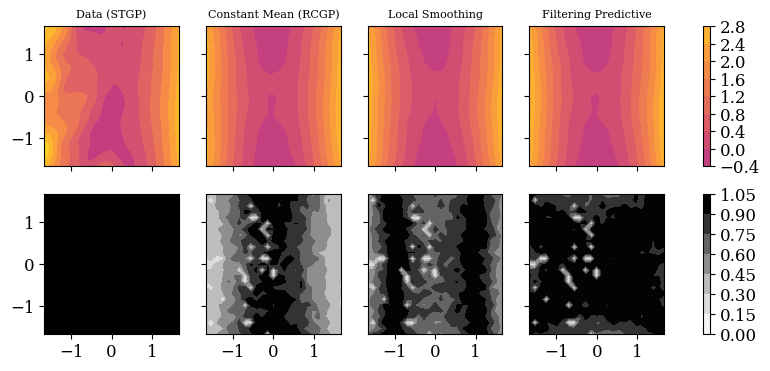

In [63]:
plot_multiple_prior_means(idx=1, grid=grids[0], data=Ys_no_outliers, data_fit=Ys, vmin=-4, vmax=4)

### Well-Specified

Data (STGP) : 
Efficiency : tensor(1.)
NLPD :  -0.2242326
RMSE :  0.1845884
Constant Mean (RCGP) : 
Efficiency : tensor(0.6617)
NLPD :  -0.17786032
RMSE :  0.18834375
Local Smoothing : 
Efficiency : tensor(0.7929)
NLPD :  -0.2011182
RMSE :  0.18687546
Filtering Predictive : 
Efficiency : tensor(0.9286)
NLPD :  -0.21728997
RMSE :  0.1848016


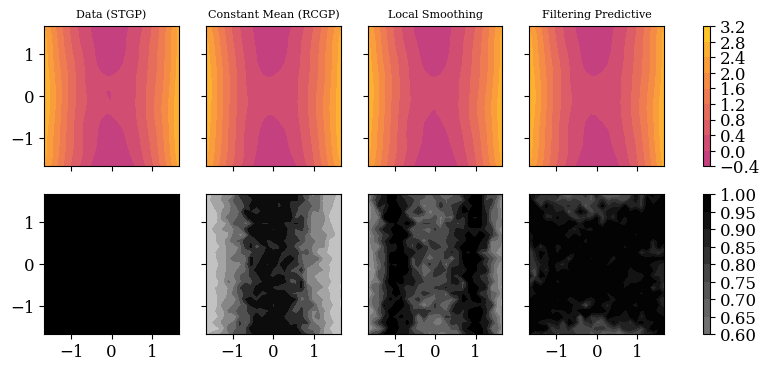

In [64]:
plot_multiple_prior_means(idx=1, grid=grids[0], data=Ys_no_outliers, data_fit=Ys_no_outliers, vmin=-4, vmax=4)